In [1]:
import uproot3 as uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def loadSingleFile( tfile, treename, flatenndf=False ):
    ttree = uproot.open(tfile)
    data = ttree[treename].arrays(outputtype=pd.DataFrame,flatten=flatenndf)
    return data

def loadFiles( filelist, treename1, treename2, maxfiles=100, flatenndf=False):
    data1 = pd.DataFrame()
    data2 = pd.DataFrame()
    for i,tfile in enumerate(filelist[0:maxfiles]):
        if i%10 == 0:
            print("{} files processed".format(i))
        ttree = uproot.open(tfile)
        data1 = pd.concat([data1, ttree[treename1].arrays(outputtype=pd.DataFrame,flatten=flatenndf)])
        data2 = pd.concat([data2, ttree[treename2].arrays(outputtype=pd.DataFrame,flatten=flatenndf)])
    return data1, data2

In [2]:
### PREPARE DATA ####
MATCHES = "../output/run8413_matched_light_tracks.txt"
LIGHTINFO = "../inputs/run8413_tracks_BNB_files.txt"
FILENAMES = [ line.strip() for line in open(LIGHTINFO, "r") ]

FILENAME = FILENAMES[0] # choose one!
print(FILENAME)

root://fndca1.fnal.gov:1094/pnfs/fnal.gov/usr/icarus/persistent/calibration/calib_ntuples/data/v09_37_02_06/bnb/run/84/13/hist_data_dl4_fstrmBNB_run8413_15_20220524T034439_20220606T160023_pot_20220606T172159_stage0_20220607T075550_stage1-95adf64a-686a-4fa6-b510-79b7a3b86342.root


In [3]:
### Get optical data
dfw = loadSingleFile(FILENAME, "simpleLightAna/opflashCryoW_flashtree")
dfe = loadSingleFile(FILENAME, "simpleLightAna/opflashCryoE_flashtree")
dfw["cryo"] = 1
dfe["cryo"] = 0
df = pd.concat([dfe, dfw])
df = df.drop(columns=["multiplicity","multiplicity_right","multiplicity_left","sum_pe","sum_pe_right","sum_pe_left"])
del dfw
del dfe

dfopw = loadSingleFile(FILENAME, "simpleLightAna/opflashCryoW_ophittree")
dfope = loadSingleFile(FILENAME, "simpleLightAna/opflashCryoE_ophittree")
dfope["cryo"] = 0
dfopw["cryo"] = 1
dfop = pd.concat([dfope, dfopw])                
del dfopw
del dfope

### Get the geometry
geo = loadSingleFile(FILENAME, "simpleLightAna/geotree")
x = geo.pmt_x.values[0] ; y = geo.pmt_y.values[0] ; z = geo.pmt_z.values[0]
dfop["pmt_x"] = [ x[ch] for ch in dfop.channel_id.values ] 
dfop["pmt_y"] = [ y[ch] for ch in dfop.channel_id.values ] 
dfop["pmt_z"] = [ z[ch] for ch in dfop.channel_id.values ]
geo.to_csv("pmt_positions.csv")
del geo

### Combine together
dfop = dfop.groupby(["run", "event", "cryo","flash_id","channel_id"]).agg({ "start_time":"min", "pmt_y":"mean", "pmt_x":"mean", "pe":"sum", "pmt_z":"mean" }).reset_index()
dfop = dfop.groupby(["run", "event", "cryo","flash_id"]).agg(list)
dfop.rename(columns={'start_time':"time_pmt", "pe":"pe_pmt"}, inplace=True)
df = (df.join( dfop, on=["run", "event", "cryo", "flash_id"], how='inner'))

del dfop

### Now match with the selected tracks
dfmatches = pd.read_csv(MATCHES)
dfmatches.rename(columns={'flashID':"flash_id"}, inplace=True)
dfmatches.set_index(["run", "event", "cryo", "flash_id"], inplace=True)
df = (df.join( dfmatches, on=["run", "event", "cryo", "flash_id"], how='inner'))

print("Consider {} tracks".format( len(df) ) )

OSError: [FATAL] Auth failed: No protocols left to try

In [ ]:
df.head(10)

In [ ]:
## Explode the dataframe 
df = df.explode(["time_pmt", "pmt_x", "pmt_y", "pe_pmt", "pmt_z", "channel_id"])

## Import and use laser correction
## WARNING: DO NOT USE IF CORRECTIONS WERE ALREADY APPLIED AT STAGE0 
## note: laser corrections are in ns!

LASERCORR="../inputs/laser_time_corrections_20220408.csv"
lasercorr = pd.read_csv(LASERCORR).set_index(["channel_id"])
lasercorr['t_signal'] = lasercorr['t_signal']/1e3  #convert ns to us

df = df.join( lasercorr[["t_signal"]], on=["channel_id"])
df['time_pmt'] = df['time_pmt'] - df['t_signal']

In [ ]:
def _seltpc(xx):
    if xx < -200:
        return 0
    elif xx < -20 and xx > -200:
        return 1
    elif xx > 20 and xx < 200:
        return 2
    elif xx > 200:
        return 3
    
EVENT=13571
CRYO=0
FLASH=2
PECUT = 100

# Keep only the reference event
df["tpc"] = [ _seltpc(val) for val in df.pmt_x.values ]
evtdf = df[(df.event==EVENT) & (df.cryo==CRYO) & (df.flash_id==FLASH)]

NameError: name 'evtdf' is not defined

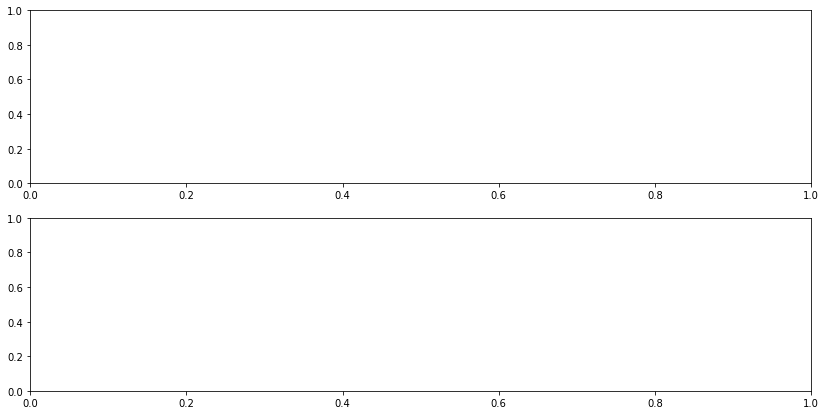

In [4]:
# Here we make the plots 
fig, ax = plt.subplots( 2,1, figsize=(14, 7) )

for i, name in enumerate(["EE", "EW", "WE", "WW"]):
    
    _stpc=evtdf.tpc==i
    tpc = evtdf[_stpc]
    
    if(len(tpc) ==0 ):
        print("EMPTY " + name )
        continue
    
    _sel = tpc["pe_pmt"] > PECUT
        
    sizes = pd.to_numeric(tpc[_sel].pe_pmt, errors='coerce')
    
    out1 = ax[i].scatter( x = tpc[_sel].pmt_z, y = tpc[_sel].pmt_y, s=sizes*0.2, c= tpc[_sel].time_pmt, cmap='jet')
    fig.colorbar( out1, ax=ax[i], label="Pulse start time [us]", pad=0.01 )
    ax[i].scatter(x=z,y=y,s=0.2,c="black")
    ax[i].plot( [evtdf.trackStartZ, evtdf.trackEndZ], [evtdf.trackStartY, evtdf.trackEndY], color='black' )
    
    
for i in range(2):
    ax[i].set_ylabel("Y [cm]")
    ax[i].set_xlabel("Z [cm]")
    ax[i].set_xlim( (-980, 980) )
    ax[i].set_ylim( (-160, 110) )
    ax[i].grid(alpha=0.5, linestyle="dashed") 
    
#plt.tight_layout()
#plt.savefig("../figs/run8413_event2d_{}_cryo_{}_flash_{}_PE100.png".format(EVENT,CRYO,FLASH),dpi=100)

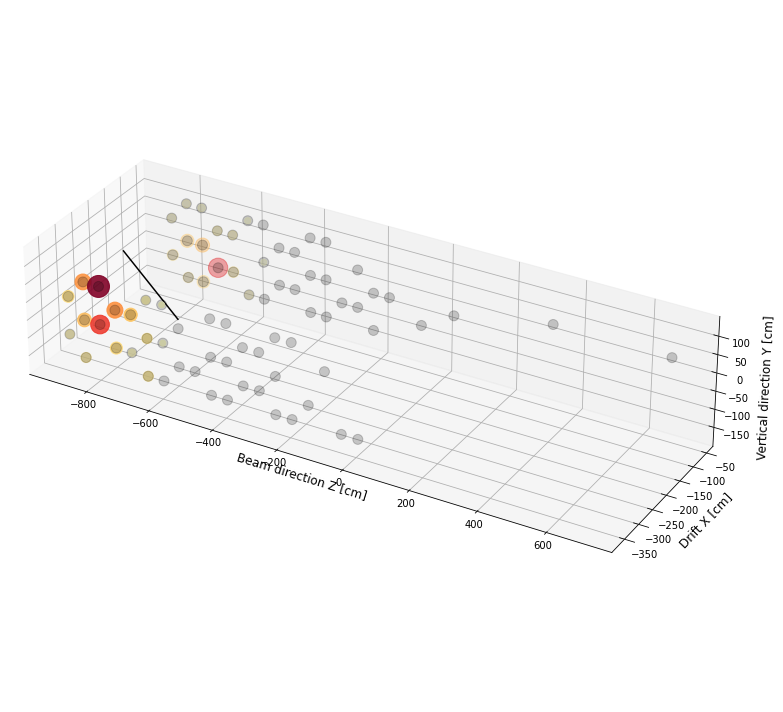

In [19]:
# PLOT in 3D 
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(projection='3d')

_selcryo=evtdf.cryo==CRYO
allcryo = evtdf[_selcryo]

_sel = allcryo.pe_pmt > PECUT
sizes = pd.to_numeric(allcryo[_sel].pe_pmt, errors='coerce')

_selpmt = allcryo.pmt_x>0
if CRYO == 0:
    _selpmt = allcryo.pmt_x<0

ax.scatter( allcryo.pmt_z[_selpmt], allcryo.pmt_x[_selpmt], allcryo.pmt_y[_selpmt], c='black', s=100, alpha=0.2  )
out1 = ax.scatter( allcryo[_sel].pmt_z, allcryo[_sel].pmt_x , allcryo[_sel].pmt_y, s=sizes*0.3, c=sizes, cmap='YlOrRd' )
    
ax.plot( [evtdf.trackStartZ.values[0], evtdf.trackEndZ.values[0]], [evtdf.trackStartX.values[0], evtdf.trackEndX.values[0]], [evtdf.trackStartY.values[0], evtdf.trackEndY.values[0]], color='black' )


ax.set_box_aspect(aspect = (9, 3, 2))

ax.set_ylabel("Drift X [cm]", fontsize=12)
ax.set_xlabel("Beam direction Z [cm]",fontsize=12)
ax.set_zlabel("Vertical direction Y [cm]", fontsize=12)
    
fig.tight_layout()
#plt.savefig("../figs/run8413_event3d_{}_cryo_{}_flash_{}.png".format(EVENT,CRYO,FLASH),dpi=100)

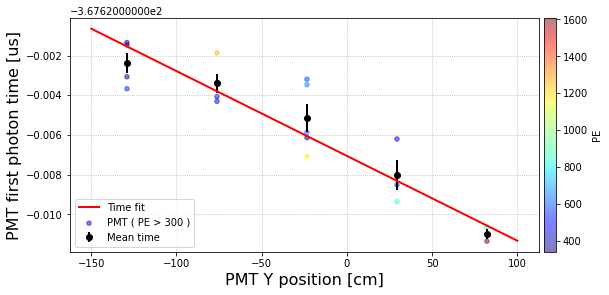

In [22]:
_pecut=300

_sel = evtdf.pe_pmt > _pecut
evtmdf = evtdf[_sel][["time_pmt", "pe_pmt", "pmt_y"]].groupby("pmt_y").apply( 
    lambda x : pd.Series( {
        "mean_time" : np.mean(x.time_pmt),
        "weight_mean_time" : np.average(x.time_pmt, weights=x.pe_pmt), 
        "error_mean_time": np.std(x.time_pmt) / np.sqrt(len(x.time_pmt))
    }) ).reset_index()

fig, ax = plt.subplots( 1,1, figsize=(10, 4.3) )

out = ax.scatter( evtdf[_sel].pmt_y, evtdf[_sel].time_pmt, c=evtdf[_sel].pe_pmt, s=20, label='PMT ( PE > {} )'.format(_pecut), cmap='jet', alpha=0.5 )
fig.colorbar( out, ax=ax, label="PE", pad=0.01 )

#ax.errorbar( x=evtmdf.pmt_y, y=evtmdf.weight_mean_time, yerr=evtmdf.error_mean_time, marker='o', elinewidth=2.0, lw=0, label='Weighted mean time', color='grey' )
ax.errorbar( x=evtmdf.pmt_y, y=evtmdf.mean_time, yerr=evtmdf.error_mean_time, marker='o', elinewidth=2.0, lw=0, label='Mean time', color='black' )

res = stats.linregress( evtmdf.pmt_y, evtmdf.weight_mean_time ) 
ax.plot( np.linspace(-150, 100),  np.linspace(-150, 100)*res.slope+res.intercept, lw=2.0, color='red', label='Time fit' )

ax.set_ylabel("PMT first photon time [us]", fontsize=16)
ax.set_xlabel("PMT Y position [cm]", fontsize=16)
ax.legend(loc='lower left')
ax.grid(linestyle="dotted")
plt.savefig("../figs/run8413_residuals_{}_cryo_{}_flash_{}_new.png".format(EVENT,CRYO,FLASH),dpi=100)